In [1]:
#!/usr/bin/python
import warnings
warnings.filterwarnings('ignore')
from ggplot import *
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data,test_classifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

C:\Python\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 通过算法想解决的问题：

这个数据集中安然公司破产后，美国在公开审理的其诈骗案件中向公众发布的关于安然公司140多位公司高管的财务和邮件信息。  
同时数据集中已经对每个人的信息提供了标签来告知该人是否为嫌疑人（poi特征）  
这里我们希望能够利用该数据集和机器学习的监督学习算法来判断哪些人是嫌疑人。  

# 数据探索

## 数据概况

首先将数据导入进项目中并查看数据结构：

In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
my_dataset = data_dict

data_df = pd.DataFrame(my_dataset).T
pd.set_option('display.max_columns', 30) 
pd.set_option('display.max_rows', 300) #& (data_df["poi"]==True)
data_df = pd.DataFrame(my_dataset).T
print "数据集数量：", len(data_df),"\n","poi数量：", \
len(data_df[data_df["poi"]==True]), "\n","特征数量：", len(data_df.columns)-1

数据集数量： 146 
poi数量： 18 
特征数量： 20


数据集中有146条信息，其中嫌疑人(poi)有18人，共有20个特征（poi列为标签）。

In [3]:
data_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,NaN,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,NaN,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,NaN,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,NaN,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


## 机器学习策略

### 评估指标策略

该数据集具有不平衡性，`poi=True`的比例只占了$12.3\%$，因此常规的Accuracy指标（即能将poi的判断为poi，能将非poi的判断为非poi）指标并不能很好评价算法  
即使我们算法全部失效（即所有人都判断为非poi），其Accuracy仍有： $100\% - 12.3\% = 87.7\%$ 的正确率，使得无法判别不同算法的好坏  
在这我们使用Precision和Recall作为该项目的评估指标：  

|        指标      |              说明                            | 
| :--------------: | :-----------------------------------------: |
| Precision        | 预测正确的poi数占预测为poi总数的比率           |
| Recall           | 预测正确的poi数占真正的poi总数的比率           |  

同时这两个指标中，recall最重要。  
比如说100个人里面有10个是坏人，我们通过算法从100个人里预测了A是坏人，而A确实是坏人，则我们的Precision $= 1 \,\div \, 1 = 1$，只能说明我们预测出的坏人是否为真正的坏人，无法告诉我们是否已经预测出了所有坏人  
但是我们没法说这个算法是优秀的，因为它漏掉了其他9个坏人，这时 recall $= 1 \, \div \, 10 = \,0.1$，这个指标更能反应算法的实际表现


### 交叉验证策略

我们将数据集的$30\%$作为测试集，发现整个测试集中的数据量只有40+条，使得我们对该测试集得到的数据结果的可信度抱有疑问，这40+条数据是否真能测试该算法的泛化能力，即出现没见过的事件是否能真如验证中的表现：  

因此在这里我们使用tester.py中的test_classifier函数。即通过使用 StratifiedShuffleSplit 方法将数据集随机分成10份（并保持各份中的标签比例与原数据比例大致相同）。  
我们用得到的分类器（clf）对其中的9份数据进行学习，同时剩余1份用作训练集用作验证。  

在该函数中将这过程重复了1000次：这样等于我们对分类器（clf）进行1000次学习和验证，非常大大提升算法泛化能力的可信度  
在之后的分类器的分析中我们会将两种交叉验证方法的结果都列出来，前者原有测试集的验证结果作为参考，以test_classifier函数的验证结果为准，并且期间可以观察只有40+条数据量的交叉验证是否稳健，并可以在最后对此下相关结论

### 算法调参策略

由于该数据集只有140+条数据，运行周期较短，这里考虑用 GridSearchCV 方法对算法进行调参。当然如果遇到数据数量较大的数据集，运行周期较慢的情况下可以考虑用 RandomizedSearchCV 方法对算法进行调参

## 特征中缺失值（NaN）的占比

In [4]:
name = []; value = []
for x in data_df:  # 查看每个特征中有多少的缺失值NaN
    name.append(x+":")
    value.append(round(sum(data_df[x]=="NaN")/146.,3))
npercent = pd.DataFrame(value, index=name,columns=["NaN percent"])
npercent.sort_values("NaN percent",ascending=False)

,NaN percent
loan_advances:,0.973
director_fees:,0.884
restricted_stock_deferred:,0.877
deferral_payments:,0.733
deferred_income:,0.664
long_term_incentive:,0.548
bonus:,0.438
from_messages:,0.411
from_poi_to_this_person:,0.411
from_this_person_to_poi:,0.411


从上表中可以看到，`loan_advances`，`director_fees`和`restricted_stock_deferred`中缺失值的占比都超过了$80\%$，几乎不包含什么信息，在这里即可先将这三个特征排除在外

## 异常值调查

首先建立`salary`和`bonus`的散点图来查看下这两特征的关系时发现到一个明显的异常值：

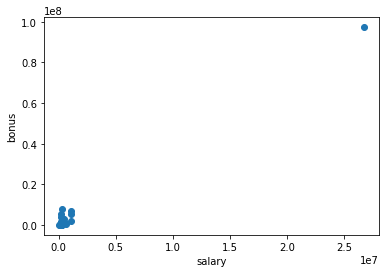

In [5]:
%matplotlib inline
plt.scatter(data_df["salary"],data_df["bonus"])
plt.xlabel("salary")
plt.ylabel("bonus")

In [6]:
data_df.loc[(data_df["salary"]>25000000) & (data_df["salary"]!="NaN"),["salary","bonus"]]

,salary,bonus
TOTAL,26704229,97343619


可以看到这个异常值是一个汇总数据（TOTAL）并非我们关注的个体数据，所以在这里将其去除:  
同时我们来看下`total_payments`，`total_stock_value`这两个特征，因为这两个特征都有个明显的特点，就是数据都应 $>0$：

In [7]:
data_df[data_df["total_payments"]<0]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


In [8]:
data_df[data_df["total_stock_value"]<0]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
BELFER ROBERT,NaN,-102500,NaN,3285,NaN,3285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,44093,NaN,NaN,NaN,102500,-44093


![image.png](typo_proof.png)

通过和文档进行比对发现`total_stock_value`为负主要是由于typo造成的，同时行数据缺失值占比较大，故在这里予以去除

In [9]:
my_dataset.pop("TOTAL")
my_dataset.pop("BELFER ROBERT")

{'bonus': 'NaN',
 'deferral_payments': -102500,
 'deferred_income': 'NaN',
 'director_fees': 3285,
 'email_address': 'NaN',
 'exercised_stock_options': 3285,
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 44093,
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 102500,
 'total_stock_value': -44093}

# 特征选择

## 创建新特征

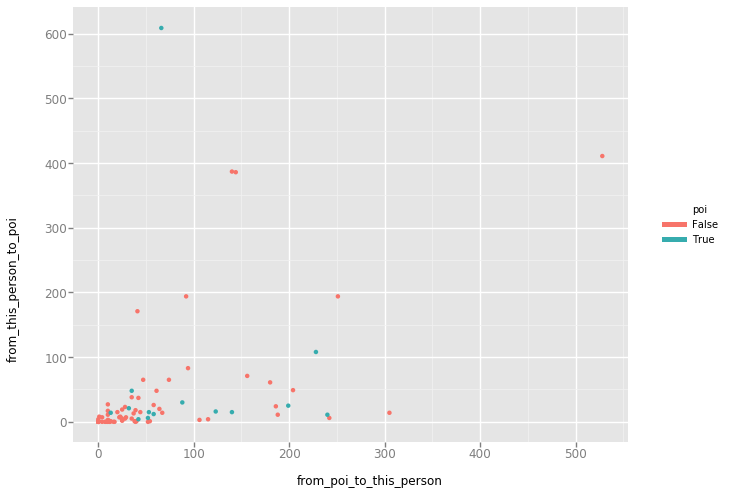

<ggplot: (14432940)>

In [10]:
ggplot(data_df, aes(x= "from_poi_to_this_person",y="from_this_person_to_poi",color = "poi")) + geom_point()

数据集中关于邮件信息的特征主要包含五个：`from_messages`，`from_poi_to_this_person`，`from_this_person_to_poi`，`shared_receipt_with_poi`和`to_messages`  
从上图中`from_poi_to_this_person`,`from_this_person_to_poi`的散点图中很难看出poi与非poi之间的关系，同时这5个特征有很强的关联，不适合全部引入模型中。  
这里通过创建新的邮件特征来汇总这些信息：  
$$
mail\_poi\_rate \,=\, {(\,from\_this\_person\_to\_poi + from\_poi\_to\_this\_person + shared\_receipt\_with\_poi\,) \over (\,from\_messages + to\_messages\,)}
$$

In [11]:
def mail_percent(data = None): # 生成该人与poi有关的邮件比例，并将值返回给mail_poi_percent
    for person in data:  
        if data[person]["from_messages"]=="NaN": #                     
            data[person]["mail_poi_rate"] = 0
        else:
            if not (data[person]["from_messages"] + data[person]["to_messages"]):
                data[person]["mail_poi_rate"] = 0
            else:
                data[person]["mail_poi_rate"] = float((
                    data[person]["from_this_person_to_poi"] +   
                    data[person]["from_poi_to_this_person"] + 
                    data[person]["shared_receipt_with_poi"])) / \
                    (data[person]["from_messages"]+data[person]["to_messages"])
                
mail_percent(my_dataset)

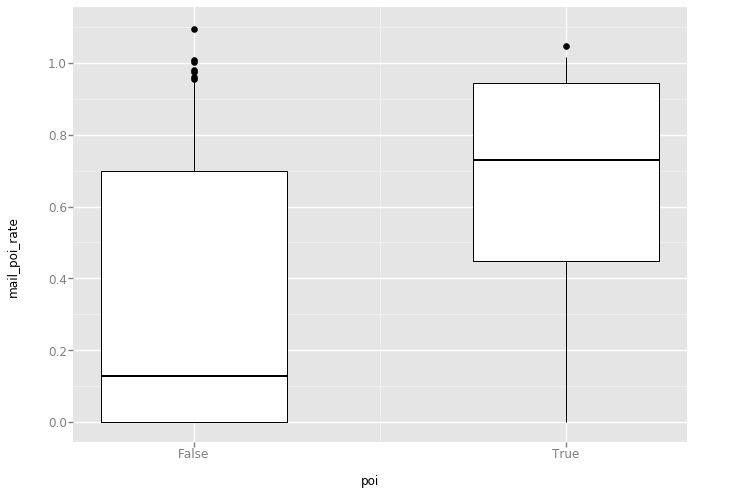

<ggplot: (17405044)>

In [12]:
data_df = pd.DataFrame(my_dataset).T
ggplot(data_df, aes(x='poi', y='mail_poi_rate')) +geom_boxplot()

从图上可以看出新创建的邮件特征`mail_poi_rate`非常好的体现了poi与非poi之间所处的不同范围，差异性表现良好

## 初步选择特征

结合上面分析，引入新创建的邮箱特征`mail_poi_rate`，去除原先的邮件特征，和因为缺失值占比太高的三个特征：`loan_advances`，`director_fees` 和 `restricted_stock_deferred`  
将其余特征都引入所需要的特征范围中，并对缺失值（NaN）用$0$替代

In [13]:
### 这里的features_list第一个元素必须是标签（poi）
features_list = ["poi","bonus","deferral_payments","deferred_income","exercised_stock_options",
                 "expenses","long_term_incentive","mail_poi_rate","other",
                 "restricted_stock","salary","total_payments","total_stock_value"]

### 在这里将数据集写入adarray，同时缺失值用0替代
data = featureFormat(my_dataset, features_list, sort_keys = True) 
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

## 各特征的重要性分析

目前纳入考虑的特征数量共12个，同时并不是每一个特征都对于我们想要解决的问题有帮助，或者说帮助不大，这里通过Kbest方法来查看各个特征的重要程度：

In [42]:
kbest = SelectKBest(k=7)
kbest.fit(features_train,labels_train)

SelectKBest(k=7, score_func=<function f_classif at 0x00000000102464A8>)

In [43]:
feature_importance = pd.DataFrame(zip(features_list[1:],kbest.scores_),columns=["name","importance"])
feature_importance.sort_values("importance",ascending=False)


,name,importance
0,bonus,13.362745
9,salary,9.779358
6,mail_poi_rate,8.734778
2,deferred_income,6.592103
11,total_stock_value,4.678478
3,exercised_stock_options,4.473651
4,expenses,3.452298
10,total_payments,3.142229
5,long_term_incentive,2.528255
8,restricted_stock,2.373655


从上表中我们发现最后几个特征的重要程度已经非常低了，引入模型就显得非常不划算
在这里我们取原来特征数量的$60\%$,即7个最主要的特征进行之后的分类分析

In [44]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi","bonus","deferred_income","exercised_stock_options",
                 "expenses","mail_poi_rate","salary","total_stock_value"]

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

最后选择的特征为：`bonus`，`deferred_income`，`exercised_stock_options`，`expenses`，`mail_poi_rate`，`salary`，`total_stock_value`  
同时将数据按7：3的比例分成训练集（features_train,  labels_train）和测试集（features_test,  labels_test）

# 分类器学习和验证

## 朴素贝叶斯

首先运用 GaussianNB 分类器对于训练集进行学习，并在测试集上进行验证：

In [45]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
labels_pred = clf.predict(features_test)

In [46]:
print "accuracy :", accuracy_score(labels_pred,labels_test)
print "precision: ", precision_score(labels_pred,labels_test)
print "recall: ", recall_score(labels_pred,labels_test)
print "f1:", f1_score(labels_pred,labels_test)
print "测试集中的数据量：", len(labels_test)

accuracy : 0.857142857143
precision:  0.333333333333
recall:  0.5
f1: 0.4
测试集中的数据量： 42


In [47]:
test_classifier(clf, my_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.86171	Precision: 0.52105	Recall: 0.39600	F1: 0.45000	F2: 0.41597
	Total predictions: 14000	True positives:  792	False positives:  728	False negatives: 1208	True negatives: 11272




| Accuracy | Precision | Recall   |
| :------: | :-------: | :------: |
| 0.86171  | 0.52105   | 0.39600  |  

得到的结果较为理想。

## 决策树

由于该数据集中出现了较多的缺失值，同时很多特征的Scale也不太相同，因此这里非常适合使用决策树进行学习和分类

In [48]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(features_train,labels_train)
labels_pred = clf.predict(features_test)

In [49]:
print "accuracy :", accuracy_score(labels_pred,labels_test)
print "precision: ", precision_score(labels_pred,labels_test)
print "recall: ", recall_score(labels_pred,labels_test)
print "f1:", f1_score(labels_pred,labels_test)

accuracy : 0.785714285714
precision:  0.333333333333
recall:  0.285714285714
f1: 0.307692307692


In [50]:
test_classifier(clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.79429	Precision: 0.28431	Recall: 0.29000	F1: 0.28713	F2: 0.28884
	Total predictions: 14000	True positives:  580	False positives: 1460	False negatives: 1420	True negatives: 10540



| Accuracy | Precision | Recall   |
| :------: | :-------: | :------: |
| 0.79429  | 0.28431   | 0.29000  |  

默认设置下决策树的表现并不太好，至少没有比GaussianNB 分类器优秀

## 决策树---调参优化

使用 GridSearchCV 方法对决策树算法中的参数进行调整：

In [51]:
### 对决策树的参数进行调整
print "# Tuning hyper-parameters for %s" % "recall"
params = [{"max_depth":[3,5,6,7,8,10,None],"min_samples_split":[2,3,5,10],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
          "max_features":[4,5,6,7]}]
cv = StratifiedShuffleSplit(random_state = 42)

dtc = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(dtc, params,scoring='recall',cv=cv,n_jobs=-1)
clf.fit(features_train,labels_train)
print "best model parameters:", clf.best_params_


# Tuning hyper-parameters for recall
best model parameters: {'max_features': 5, 'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 1}


GridSearchCV 方法中得到的最佳参数：  
  
| max_features | min_samples_split  | max_depth   | min_samples_leaf |
| :----------: | :---------------:  | :---------: | :--------------: |
|       5      |        2           |      7      |          1       |  

并将参数输入到决策树模型中进行再次学习：

In [52]:
clf = DecisionTreeClassifier(random_state=42,min_samples_split=2,max_depth=7,min_samples_leaf=1,max_features=5) 
clf.fit(features_train,labels_train)
labels_pred = clf.predict(features_test)

In [53]:
print "accuracy :", accuracy_score(labels_pred,labels_test)
print "precision: ", precision_score(labels_pred,labels_test)
print "recall: ", recall_score(labels_pred,labels_test)
print "f1:", f1_score(labels_pred,labels_test)

accuracy : 0.785714285714
precision:  0.333333333333
recall:  0.285714285714
f1: 0.307692307692


In [54]:
test_classifier(clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
	Accuracy: 0.82043	Precision: 0.36642	Recall: 0.35250	F1: 0.35933	F2: 0.35520
	Total predictions: 14000	True positives:  705	False positives: 1219	False negatives: 1295	True negatives: 10781



从原有测试集的验证结果显示时参数有优化后的表现与之前并无不同：  
而使用更为稳健的 StratifiedShuffleSplit 方法的test_classifier函数验证得出的结果：  

| Accuracy | Precision | Recall   |
| :------: | :-------: | :------: |
| 0.82043  | 0.36642   | 0.35250  |  

发现优化后的算法在各个评估指标里都比初始的决策树表现有明显的提升。  

## 参数调整的重要性

在最大多数情况下算法的默认设置并不能充分发挥数据中的特性，从而使得最后结果表现并不理想，但是这个并不意味着这个算法就不适合解决这个问题，非常多的情况下是因为算法中的一些关键因素并没有针对该数据进行特定的优化  
就比如一个胖子穿着一件标码的衬衫，怎么穿都不合适，但将同样的衣服款式并针对这个胖子进行下量体裁衣，再试穿后就会显得非常不同，十分得体  
可见算法中参数调整的重要性和作用都是非常明显的，对于每个使用的算法我们都需要尽可能的将算法中的参数调到最优以最大化该算法的效果

# 结论

## 最终算法

最终我们选择 GaussianNB 分类器作为该问题的算法对数据进行学习和分类。其在tester.py中的验证中表现是最优异的：  

| Accuracy | Precision | Recall   |
| :------: | :-------: | :------: |
| 0.86171  | 0.52105   | 0.39600  |  
<br/>
可见对于某些情况下，简单的算法并不一定意味着糟糕的表现，甚至如本问题中可以优于其他算法。

## 验证的重要性

由于算法它趋于会对数据进行过度学习，容易出现过拟合：  
- 如果实际发生的事件是在数据中出现过，则算法会非常令人满意的决策  
- 如果实际发生的事件是在数据没有出现过，则算法不知道该对这事件怎么处理，从而给出的决策都会非常差  

将数据进行分成训练集和测试集，就是为了保证模型既能在训练集中进行学习，又能在对于没有出现在训练集里的事件里（即测试集）具有良好的泛化能力。

## 交叉验证的稳健性

在上述分析中已经发现，由于数据集中的数据量本身就小，即使将$30\%$的数据用作测试集仍只有42个，在之后的分析中发现，若只使用这少数的测试数据去判断一个算法的泛化能力是缺乏稳健的甚至可能会得到错误的结论，因此对于小数据样本中的交叉验证应考虑类似 StratifiedShuffleSplit 更为稳健的方法作为交叉验证的方法